In [2]:
import os, sys
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import joblib
sys.path.append("/home/dm/Dibyendu/Projects/CVSampler/Scripts/")
from bond_connection import ConnectionGraph

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
# Load dataset and select relevant columns
freesolv = pd.read_csv("../DataSets/Full_Free_Solv/full.csv", delimiter=";")
freesolvdf = freesolv[["SoluteSMILES", "DeltaGsolv"]]

# Generate RDKit molecule objects from SMILES
freesolvdf['mol'] = freesolvdf['SoluteSMILES'].apply(lambda x: Chem.MolFromSmiles(x))

# Get property names from RDKit
property_names = list(Chem.rdMolDescriptors.Properties().GetPropertyNames())

# Compute molecular properties for each molecule
prop_dict = {name: [] for name in property_names}
for mol in freesolvdf['mol']:
    properties = Chem.rdMolDescriptors.Properties().ComputeProperties(mol)
    for i, name in enumerate(property_names):
        prop_dict[name].append(properties[i])

# Add computed properties to the dataframe
for name in property_names:
    freesolvdf[name] = prop_dict[name]

# Count specific atom types in each molecule
for atom in ['C', 'O', 'N', 'Cl', 'F']:
    freesolvdf[f'#{atom}_atoms'] = freesolvdf['mol'].apply(
        lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(atom)))
    )

# Prepare numeric dataframe by dropping unnecessary columns
numeric_df = freesolvdf.dropna().drop(["SoluteSMILES", "mol", "NumSpiroAtoms"], axis=1)

# Compute correlation matrix
corr_mat = numeric_df.corr().to_numpy()

# Identify correlated and uncorrelated feature pairs
uncorr_pairs = []
corr_pairs = []
for i in range(len(corr_mat) - 1):
    for j in range(i + 1, len(corr_mat)):
        if corr_mat[i, j] < 0.95:
            uncorr_pairs.append([i, j])
        else:
            corr_pairs.append([i, j])

# Create connection graph from correlated pairs
list_final = np.array(corr_pairs)
connection_graph = ConnectionGraph(list_final)
connections = connection_graph.get_connected_bond_list()

# Exclude connected bonds from uncorrelated pairs
exclude = np.concatenate([connections[i][1:] for i in range(len(connections))])
uncorr_feature_index = np.arange(len(numeric_df.keys()))[~np.isin(np.arange(len(numeric_df.keys())), exclude)]

# Create final dataframe with uncorrelated features
final_df = numeric_df[numeric_df.keys().to_numpy()[uncorr_feature_index]]

[23:00:02] WARNING: not removing hydrogen atom without neighbors


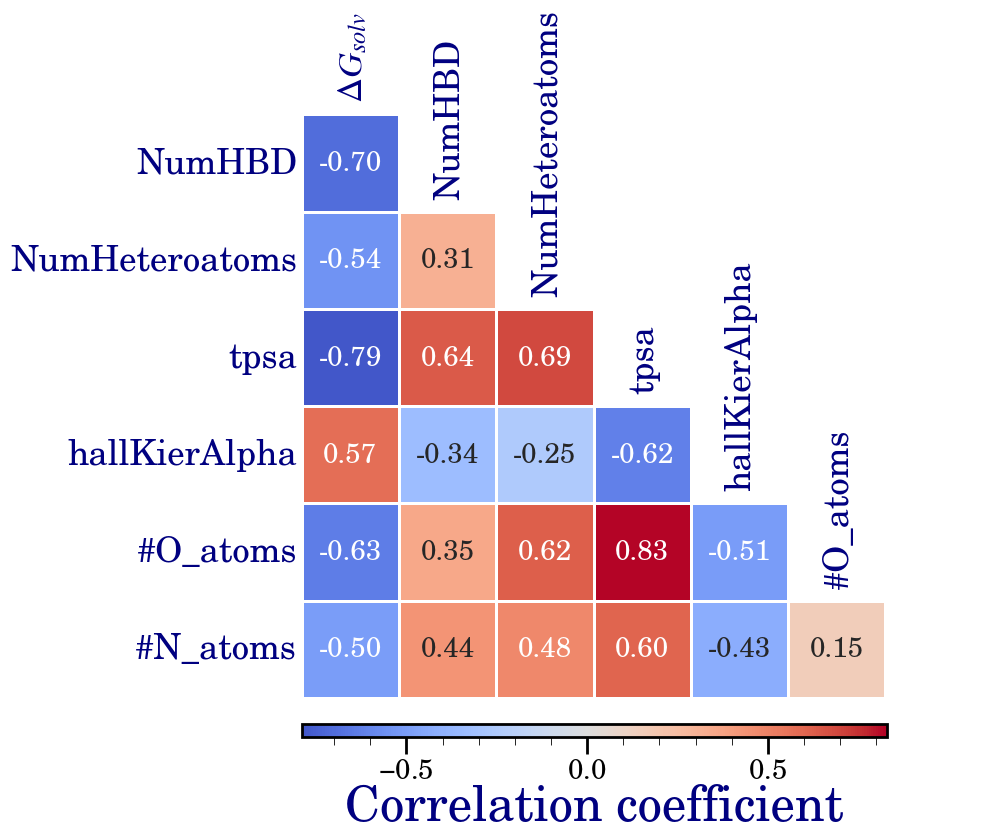

In [24]:
ndf = final_df[['DeltaGsolv', 'NumHBD', 'NumHeteroatoms', 'tpsa',
       'hallKierAlpha', '#O_atoms', '#N_atoms']]

fig, ax = plt.subplots(figsize=(10, 10))
#ndf = df[["HCT",'Time ratio','Temp Ratio',
#    'Gradient time ratio', ' Ratio of Rate', 'Zblood/Zwater']]
#ndf = ndf[['Age', 'Sex', "HCT",'Time ratio = (tblood / twater)','Temp Ratio = (Tblood/Twater)',
#    'Gradient time ratio tGDblood / tGblood', ' Ratio of Rate = Rblood/ Rwater', 'Zblood/Zwater']]
mask = np.zeros_like(ndf.corr(numeric_only=True), dtype=bool)
mask[np.triu_indices_from(mask)] = True

heatmapkws = dict(square=True, cbar=False, cmap = "coolwarm", linewidths=1.0 )
im = sns.heatmap(ndf.corr(numeric_only=True),  annot=True, fmt=".2f", annot_kws={"fontsize":20}, ax = ax, mask = mask,center=0,
           xticklabels=False, yticklabels=True,cbar_kws={"shrink": .75, 'orientation': 'horizontal'} ,  **heatmapkws)
ax.yaxis.set_tick_params(which="both", size=0, width=0, direction='in', right=True, left=True)

ax.set_yticklabels(["", 'NumHBD', 'NumHeteroatoms', 'tpsa',
       'hallKierAlpha', '#O_atoms', '#N_atoms'], fontsize=25, color = "navy")
labels = [r'$\Delta G_{solv}$', 'NumHBD', 'NumHeteroatoms', 'tpsa',
       'hallKierAlpha', '#O_atoms', '#N_atoms']
for i, label in enumerate(labels[:-1]):
    ax.text(x = i + 0.35, y = i +0.8, s = label, fontsize = 25, color = "navy", rotation = 90)

mappable = im.get_children()[0]
#plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.95, pad = 0.025)
cax = ax.inset_axes([0.0, -0.058, 0.86, 0.02])
cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal', label = "Correlation Coefficient",
             ticks = [-1, -0.5, 0, 0.5, 1])
cbar.set_label("Correlation coefficient", fontsize=35, color = "navy")
fig.tight_layout()
#plt.savefig("corr_map.svg")
plt.show()


In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score

# https://pandas.pydata.org
import pandas as pd

# https://numpy.org/doc/stable/release.html
import numpy as np

# #https://github.com/mordred-descriptor/mordred
# from mordred import Calculator, descriptors

import umap
from sklearn.preprocessing import MinMaxScaler

In [7]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names


In [8]:
# freesolv
freesoldf = pd.read_csv("../DataSets/freesolv.csv")
freesoldf = freesoldf.drop("Unnamed: 0", axis=1)
# MNSol
mnsoldf = pd.read_csv("../DataSets/mnsol.csv", sep = ";")
mnsoldf_water = mnsoldf.loc[mnsoldf['Solvent'] == 'water']
mnsoldf = mnsoldf_water.reset_index().drop("index", axis = 1)
# CombiSolv-EXP
combisolv = pd.read_csv("../DataSets/CombiSolv-Exp-8780.csv", sep = ",")

## Combisolv dataset preparation and cleaning..
combisolv['SolventSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[0])
combisolv['SoluteSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[1])
combisolv['Solute'] = "solute"
combisolv['Solvent'] = "solvent"
combisolv.rename(columns = {'dgsolv':'DeltaGsolv'}, inplace = True)
combisolv.drop(columns=['ssid'], inplace = True)
combisolv = combisolv.loc[combisolv['SolventSMILES'] == "O"]
combisolv.reset_index().drop("index", axis = 1, inplace = True)
combisolv = combisolv[['Solute', 'Solvent', 'SoluteSMILES',
                        'SolventSMILES', 'DeltaGsolv']]

## Smiles to Mol conversion
freesoldf['mol'] = freesoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
mnsoldf['mol'] = mnsoldf['SoluteSMILES'].apply(Chem.MolFromSmiles)
combisolv['mol'] = combisolv['SoluteSMILES'].apply(Chem.MolFromSmiles)

[23:00:05] WARNING: not removing hydrogen atom without neighbors


In [9]:
full = pd.read_csv("../DataSets/Full_Free_Solv/full.csv", delimiter=";")
## Freesolv
#freesolv = pd.read_csv("../DataSets/Full_Free_Solv/full.csv")
full = full[["SoluteSMILES", "DeltaGsolv"]]
#freesolv['fp'] = freesolv['SoluteSMILES'].apply(lambda x: MAP4.calculate(Chem.MolFromSmiles(x)))

In [10]:
Mol_descriptors,desc_names = RDkit_descriptors(full['SoluteSMILES'])
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors = df_with_200_descriptors.loc[:, df_with_200_descriptors.std() != 0]
#df_with_200_descriptors

[23:00:05] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 95, in __init__
    self.score /= self.mol.GetNumHeavyAtoms()
ZeroDivisionError: division by zero
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/

In [11]:
def getKeys(corr_thres):
    numeric_df = df_with_200_descriptors.dropna()

    corr_mat = numeric_df.corr().abs()
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > corr_thres)]

    # Drop highly correlated features
    final_df = numeric_df.drop(columns=to_drop)
    return final_df.keys()


In [12]:
keys_95 = getKeys(0.95)
keys_85 = getKeys(0.85)
keys_75 = getKeys(0.75)
keys_65 = getKeys(0.65)
keys_55 = getKeys(0.55)

In [13]:
# freesolv
freesoldf = pd.read_csv("../DataSets/freesolv.csv")
freesoldf = freesoldf.drop("Unnamed: 0", axis=1)
# MNSol
mnsoldf = pd.read_csv("../DataSets/mnsol.csv", sep = ";")
mnsoldf_water = mnsoldf.loc[mnsoldf['Solvent'] == 'water']
mnsoldf = mnsoldf_water.reset_index().drop("index", axis = 1)
# CombiSolv-EXP
combisolv = pd.read_csv("../DataSets/CombiSolv-Exp-8780.csv", sep = ",")

## Combisolv dataset preparation and cleaning..
combisolv['SolventSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[0])
combisolv['SoluteSMILES']= combisolv['ssid'].apply(lambda x: x.split(".")[1])
combisolv['Solute'] = "solute"
combisolv['Solvent'] = "solvent"
combisolv.rename(columns = {'dgsolv':'DeltaGsolv'}, inplace = True)
combisolv.drop(columns=['ssid'], inplace = True)
combisolv = combisolv.loc[combisolv['SolventSMILES'] == "O"]
combisolv.reset_index().drop("index", axis = 1, inplace = True)
combisolv = combisolv[['Solute', 'Solvent', 'SoluteSMILES',
                        'SolventSMILES', 'DeltaGsolv']]

## Adding cannonical smiles for comparison..
combisolv['cannon_smiles'] = combisolv['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))
mnsoldf['cannon_smiles'] = mnsoldf['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))
freesoldf['cannon_smiles'] = freesoldf['SoluteSMILES'].apply(lambda x : Chem.CanonSmiles(x))


[23:00:10] WARNING: not removing hydrogen atom without neighbors


In [14]:
Mol_descriptors_mnsol,desc_names = RDkit_descriptors(mnsoldf['SoluteSMILES'])
Mol_descriptors_freesoldf,desc_names = RDkit_descriptors(freesoldf['SoluteSMILES'])
Mol_descriptors_combisoldf,desc_names = RDkit_descriptors(combisolv['SoluteSMILES'])

[23:00:10] WARNING: not removing hydrogen atom without neighbors
[23:00:11] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 95, in __init__
    self.score /= self.mol.GetNumHeavyAtoms()
ZeroDivisionError: division by zero
Traceback (most recent call last):
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    re

In [15]:
def get_uncorr_dfs(keys):
    mnsol_df = pd.DataFrame(Mol_descriptors_mnsol,columns=desc_names)
    mnsol_df = mnsol_df[keys]

    freesol_df = pd.DataFrame(Mol_descriptors_freesoldf,columns=desc_names)
    freesol_df = freesol_df[keys]

    combisol_df = pd.DataFrame(Mol_descriptors_combisoldf,columns=desc_names)
    combisol_df = combisol_df[keys]
    return mnsol_df, freesol_df, combisol_df

In [16]:
mnsol_df95, freesol_df95, combisol_df95 = get_uncorr_dfs(keys_95)
mnsol_df85, freesol_df85, combisol_df85 = get_uncorr_dfs(keys_85)
mnsol_df75, freesol_df75, combisol_df75 = get_uncorr_dfs(keys_75)
mnsol_df65, freesol_df65, combisol_df65 = get_uncorr_dfs(keys_65)
mnsol_df55, freesol_df55, combisol_df55 = get_uncorr_dfs(keys_55)

In [21]:
plt.style.use('/home/dm/Dibyendu/Projects/CVSampler/NoteBooks/style.txt')
plt.rcParams['font.family'] = 'C059'

In [17]:
full_75 = df_with_200_descriptors[keys_75]
features_all = full_75.values
scaler = MinMaxScaler()
scaler.fit(features_all)
features_all_scaled = scaler.transform(features_all)

In [18]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
umap_model.fit(features_all_scaled)
umap_embedding = umap_model.transform(features_all_scaled)

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
umap_mnsol = umap_model.transform(scaler.transform(mnsol_df75.values))
umap_fsol = umap_model.transform(scaler.transform(freesol_df75.values))
umap_csol = umap_model.transform(scaler.transform(combisol_df75.values))

/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dm/anaconda3/envs/serb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


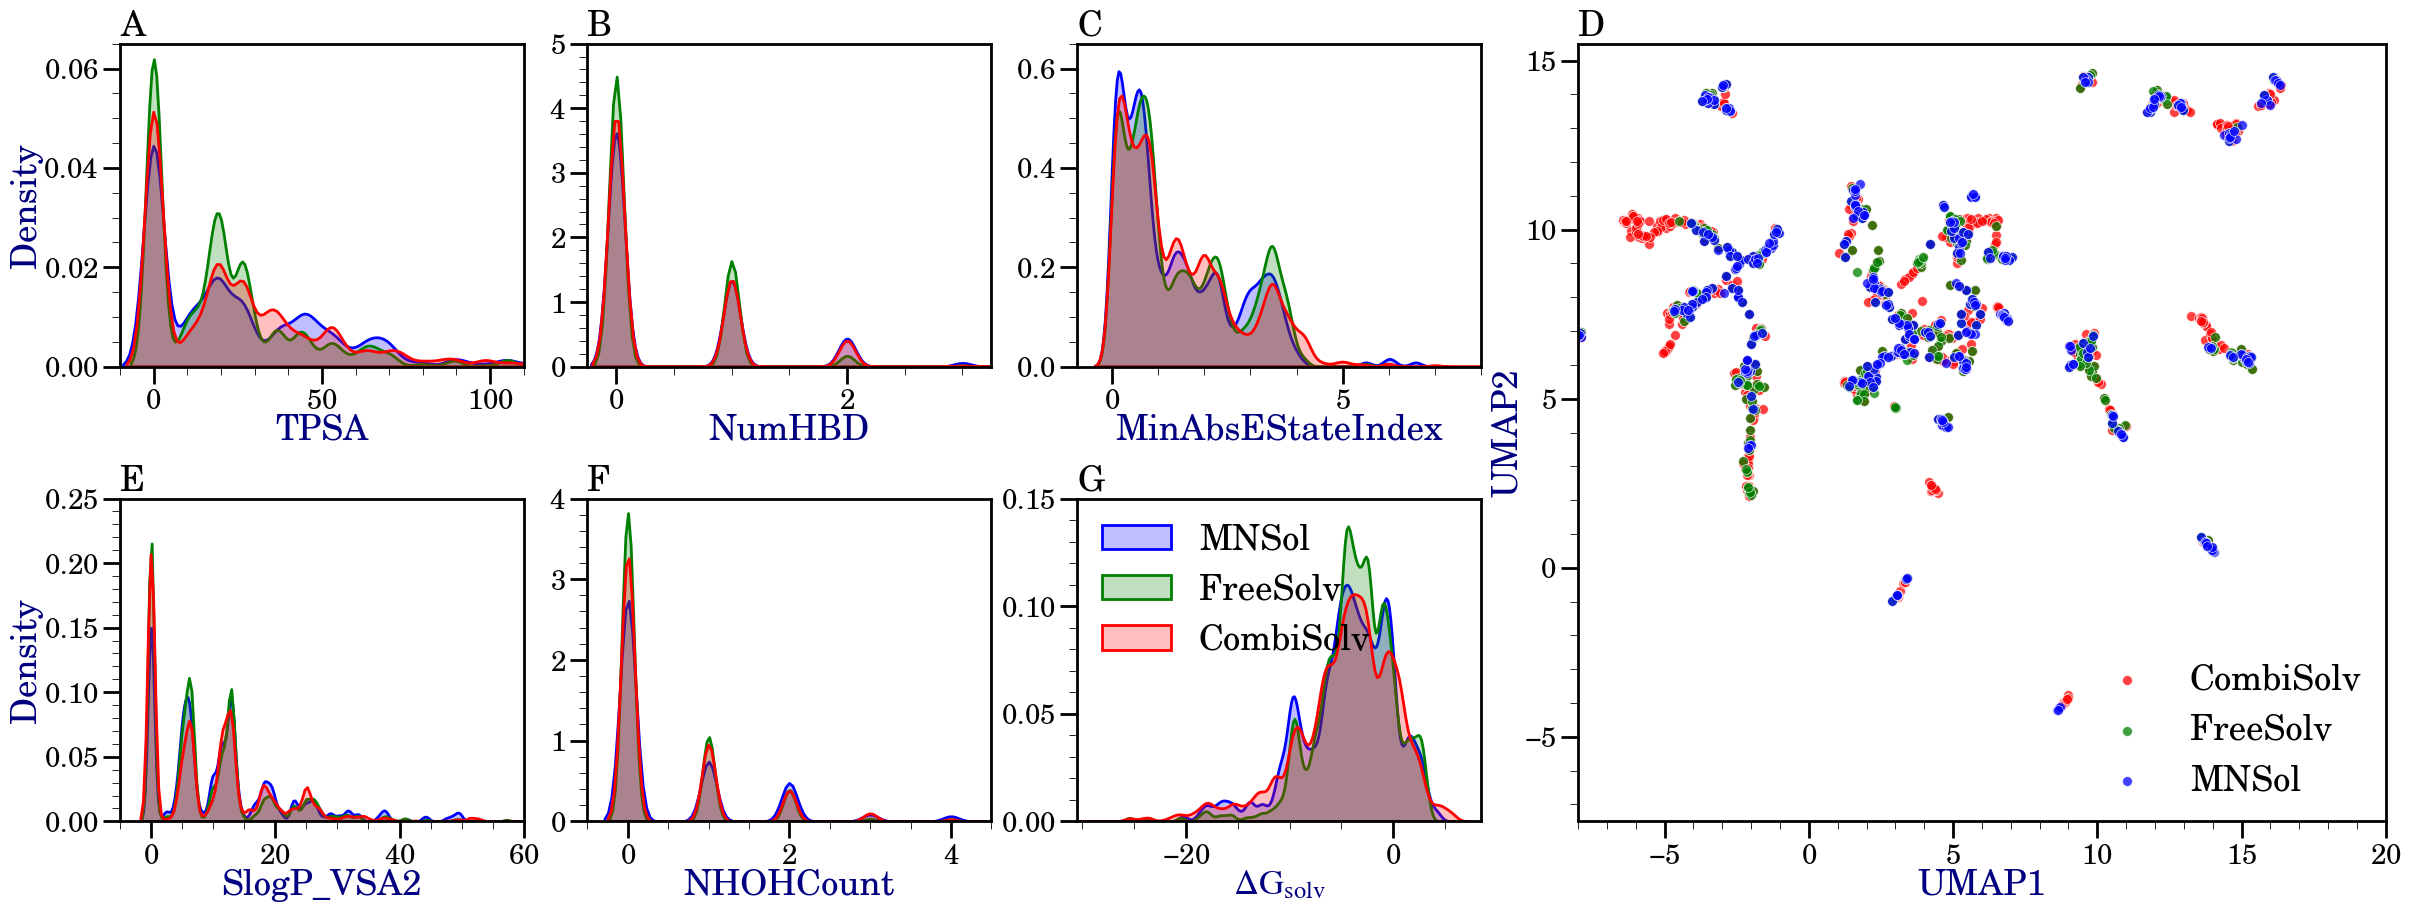

In [23]:
fig, axs = plt.subplot_mosaic([['A', 'B', 'C', 'D', 'D'], ['E', 'F', 'G', 'D', 'D']],
                              layout='constrained', figsize=(24, 9))
for label, ax in axs.items():
    ax.set_title('Normal Title', fontstyle='normal')
    ax.set_title(label, fontfamily='serif', loc='left', fontsize=25)

## TPSA
sns.kdeplot(mnsol_df75['TPSA'], bw_method=0.1, fill=True, ax=axs['A'], lw=2, color='blue')
sns.kdeplot(freesol_df75['TPSA'], bw_method=0.1, fill=True, ax=axs['A'], lw=2, color='green')
sns.kdeplot(combisol_df75['TPSA'], bw_method=0.1, fill=True, ax=axs['A'], lw=2, color='red')
axs['A'].set_xlabel("TPSA", fontsize=25, color="navy")
axs['A'].set_ylabel("Density", fontsize=25, color="navy")
axs['A'].set_xlim(-10, 110)
axs['A'].set_ylim(0, 0.065)
## NumHBD
sns.kdeplot(mnsol_df95['NumHDonors'], bw_method=0.1, fill=True, ax=axs['B'], lw=2, color='blue')
sns.kdeplot(freesol_df95['NumHDonors'], bw_method=0.1, fill=True, ax=axs['B'], lw=2, color='green')
sns.kdeplot(combisol_df95['NumHDonors'], bw_method=0.1, fill=True, ax=axs['B'], lw=2, color='red')
axs['B'].set_xlabel("NumHBD", fontsize=25, color="navy")
axs['B'].set_ylabel("", fontsize=25, color="navy")
axs['B'].set_xlim(-0.25, 3.25)

## NumHeteroatoms
sns.kdeplot(mnsol_df75['MinAbsEStateIndex'], bw_method=0.1, fill=True, ax=axs['C'], lw=2, color='blue')
sns.kdeplot(freesol_df75['MinAbsEStateIndex'], bw_method=0.1, fill=True, ax=axs['C'], lw=2, color='green')
sns.kdeplot(combisol_df75['MinAbsEStateIndex'], bw_method=0.1, fill=True, ax=axs['C'], lw=2, color='red')
axs['C'].set_xlabel("MinAbsEStateIndex", fontsize=25, color="navy")
axs['C'].set_ylabel("", fontsize=25, color="navy")
axs['C'].set_xlim(-0.75, 8)
axs['C'].set_ylim(0.0, 0.65)

## NumRotatableBonds
sns.kdeplot(mnsol_df95['SlogP_VSA2'], bw_method=0.05, fill=True, ax=axs['E'], lw=2, color='blue')
sns.kdeplot(freesol_df95['SlogP_VSA2'], bw_method=0.05, fill=True, ax=axs['E'], lw=2, color='green')
sns.kdeplot(combisol_df95['SlogP_VSA2'], bw_method=0.05, fill=True, ax=axs['E'], lw=2, color='red')
axs['E'].set_xlabel("SlogP_VSA2", fontsize=25, color="navy")
axs['E'].set_ylabel("Density", fontsize=25, color="navy")
axs['E'].set_xlim(-5.0, 60)
#axs['E'].set_ylim(0.0, 0.95)

##O_atoms
sns.kdeplot(mnsol_df75['NHOHCount'], bw_method=0.1, fill=True, ax=axs['F'], lw=2, color='blue')
sns.kdeplot(freesol_df75['NHOHCount'], bw_method=0.1, fill=True, ax=axs['F'], lw=2, color='green')
sns.kdeplot(combisol_df95['NHOHCount'], bw_method=0.1, fill=True, ax=axs['F'], lw=2, color='red')
axs['F'].set_xlabel("NHOHCount", fontsize=25, color="navy")
axs['F'].set_ylabel("", fontsize=25, color="navy")
axs['F'].set_xlim(-0.5, 4.5)
axs['F'].set_ylim(0.0, 4.0)

##N_atoms
sns.kdeplot(mnsoldf['DeltaGsolv'], bw_method=0.1, fill=True, ax=axs['G'], lw=2, color='blue', label = "MNSol")
sns.kdeplot(freesoldf['DeltaGsolv'], bw_method=0.1, fill=True, ax=axs['G'], lw=2, color='green', label = "FreeSolv")
sns.kdeplot(combisolv['DeltaGsolv'], bw_method=0.1, fill=True, ax=axs['G'], lw=2, color='red', label = "CombiSolv")
axs['G'].set_xlabel(r"$\rm \Delta G_{solv}$", fontsize=25, color="navy")
axs['G'].set_ylabel("", fontsize=25, color="navy")
axs['G'].set_xlim(-30.5, 8.5)
#axs['G'].set_ylim(0.0, 3.5)
axs['G'].legend(loc='upper left', fontsize=25)

## Scatter plot

sns.scatterplot(x = umap_csol[:, 0], y = umap_csol[:, 1], s=50, alpha=0.75, color='red', ax = axs['D'], label = "CombiSolv")
sns.scatterplot(x = umap_fsol[:, 0], y = umap_fsol[:, 1], s=50, alpha=0.75, color='green', ax = axs['D'], label = "FreeSolv")
sns.scatterplot(x = umap_mnsol[:, 0], y = umap_mnsol[:, 1], s=50, alpha=0.75, color='blue', ax = axs['D'], label = "MNSol")
axs['D'].set_xlabel("UMAP1", fontsize=25, color="navy", labelpad=0)
axs['D'].set_ylabel("UMAP2", fontsize=25, color="navy", labelpad=0)
axs['D'].set_ylim(-7.5, 15.5)
axs['D'].set_xlim(-8., 20.0)
axs['D'].legend(loc='lower right', fontsize=25)
#fig.tight_layout()
#plt.savefig("desc_ana.png")
plt.show()

## Regressors

In [27]:
#from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings

# comment out the next line to see the warning
warnings.simplefilter('ignore', category=ConvergenceWarning)
import numpy as np #type: ignore
from sklearn.svm import SVR #type: ignore
from sklearn.ensemble import RandomForestRegressor #type: ignore
from sklearn.gaussian_process import GaussianProcessRegressor #type: ignore
from sklearn.gaussian_process.kernels import RBF #type: ignore
from sklearn.kernel_ridge import KernelRidge #type: ignore
from sklearn.model_selection import GridSearchCV #type: ignore
from sklearn.linear_model import LinearRegression #type: ignore
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel #type: ignore
from xgboost import XGBRegressor #type: ignore

class Regressor:
    def __init__(self):
        pass

    def svr(self, X, y):
        hyperparameters = {'C': np.linspace(0.01,10, 20), 'gamma': np.linspace(0.01,2, 20),
                        'kernel': ['rbf']}
        model = GridSearchCV(SVR(),hyperparameters, n_jobs = -1)
        model.fit(X, y)
        return model

    #@ignore_warnings(category=ConvergenceWarning)
    def gpr(self, X, y):
        param_grid = {
            "alpha":  [1e-2, 1e-3],
            "kernel": [RBF(l) for l in np.logspace(-6, 2, 10)]
        }

        gp = GaussianProcessRegressor()

        clf = GridSearchCV(estimator=gp, param_grid=param_grid, cv=5, n_jobs = -1)
        clf.fit(X, y)
        return clf
    def krr(self, x, y):

        # Define kernel function
        kernel = 'rbf'

        # Define hyperparameters to optimize
        hyperparameters = {'alpha': np.linspace(0.01,2, 20), 'gamma': np.linspace(0.01,2, 20)}

        # Train kernel ridge regression model with cross-validation
        model = GridSearchCV(KernelRidge(kernel=kernel), hyperparameters, cv=5, n_jobs = -1)
        model.fit(x, y)

        return model

    def lr(self, x, y):

        model = LinearRegression()
        model.fit(x, y)

        return model

    def rfr(self, x, y):

        param_grid = {
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        rfr = RandomForestRegressor()
        grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_squared_error')

        grid_search.fit(x, y)
        #best_model = grid_search.best_estimator_

        return grid_search

    def xgbr(self, X, y):
        # Create an XGBoost regressor object
        xgbr = XGBRegressor()

        # Define the hyperparameters to be tuned
        param_grid = {'n_estimators': [100, 500, 1000],
                    'max_depth': [3, 5, 7],}

        # Perform grid search to find the best hyperparameters
        grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=5, n_jobs=1)
        grid_search.fit(X, y)

        return grid_search

def make_tests(X, y):
    indices = np.arange(len(y))
    X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X, y.ravel(),indices, train_size = 0.8, shuffle = True)
    return X_train, X_test, y_train, y_test, indices_train, indices_test
def model_score(model, X ,y):
    predicted = model.predict(X).reshape(-1, 1)
    blow_up_index = np.where(abs(predicted)>100)[0]
    normal = np.arange(len(y))[~np.isin(np.arange(len(y)), blow_up_index)]
    y = y[normal]
    predicted = predicted[normal]
    #print(np.max(np.abs(predicted - y)))
    r2 = r2_score(predicted, y)
    mse = mean_squared_error(predicted, y)
    return r2, mse
def cross_validate_model(X, y, model, n_splits=10):
    scores = []
    for i in range(n_splits):
        X_train, X_test, y_train, y_test, indices_train, indices_test = make_tests(X, y)
        trained_model = model.fit(X_train, y_train)
        scores.append(model_score(trained_model, X_test, y_test))
    return np.array(scores)

def summarize_scores(scores):
    mse_mean = np.mean(scores[:, 1])
    r2_mean = np.mean(scores[:, 0])
    mse_std = np.std(scores[:, 1]) / np.sqrt(len(scores))
    r2_std = np.std(scores[:, 0]) / np.sqrt(len(scores))
    return mse_mean, r2_mean, mse_std, r2_std

In [28]:
rfr = RandomForestRegressor()
scores_rfr_mnsol75 = cross_validate_model(mnsol_df75, mnsoldf['DeltaGsolv'].values , rfr)
rfr = RandomForestRegressor()
scores_rfr_fsol75 = cross_validate_model(freesol_df75, freesoldf['DeltaGsolv'].values , rfr)
rfr = RandomForestRegressor()
scores_rfr_csol75 = cross_validate_model(combisol_df75, combisolv['DeltaGsolv'].values , rfr)

NameError: name 'train_test_split' is not defined